# Master Fusion Hands-on RF Directional Coupler and Travelling Wave Antenna

In [1]:
%pylab 
%matplotlib inline
import skrf as rf

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Variable Coupler

A variable coupling coefficient coupler is a coupler which the coupling coefficient can be adjusted. It is possible to create such a coupler using two hybrid couplers and a phase shifter, as illustrated by the figure below: 

![adjustable directional coupler](Figures/Adjustable_Coupler.png)

In [2]:
freq = rf.Frequency(start=50, stop=50, npoints=1, unit='MHz')
freq

50.0-50.0 MHz, 1 pts

In [14]:
coax = rf.media.DefinedGammaZ0(frequency=freq)
print(coax)

In [15]:
# create and return a phase shifter of a specific angle 
def phase_shifter(phase_deg):
    return coax.line(d=phase_deg, unit='deg')

In [57]:
"""
3 dB hybrid
              _________
Input     1 --|       |-- 2 Through
              |       |
Isolated  4 --|_______|-- 3 Coupled

"""
def hybrid():
    Sc = 1/sqrt(2)*np.array([[0,1,1j,0], 
                             [1,0,0,1j], 
                             [1j,0,0,1], 
                             [0,1j,1,0]])
    hybrid = rf.Network(frequency=freq, s=Sc, name='hybrid')
    return hybrid

print(hybrid())

4-Port Network: 'hybrid',  50.0-50.0 MHz, 1 pts, z0=[50.+0.j 50.+0.j 50.+0.j 50.+0.j]


In [58]:
def variable_coupler(phase_deg):
    ps = phase_shifter(phase_deg)
    hybrid1, hybrid2 = hybrid(), hybrid()
    #hybrid2.z0 = [21,22,23,24]
    _temp = rf.connect(hybrid1, 2, ps, 0)
    _temp = rf.connect(_temp, 1, hybrid2, 0)
    _temp = rf.innerconnect(_temp, 1, 5)
    _temp.renumber([2, 3, 1], [1, 2, 3])
    return _temp

In [61]:
C = []
phases = np.arange(0, 360)

for phase in phases:
    vc = variable_coupler(phase)
    C.append(vc.s @ r_[1,0,0,0])
C = np.array(C)

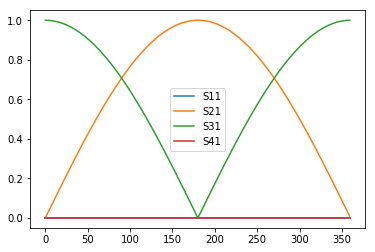

In [64]:
plot(phases, np.abs(C.squeeze()))
legend(('S11', 'S21', 'S31', 'S41'))

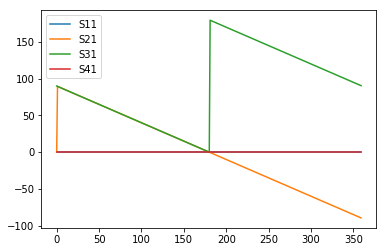

In [67]:
plot(phases, 180/pi*np.angle(C.squeeze()))
legend(('S11', 'S21', 'S31', 'S41'))

## Resonant Ring

![Resonant Ring](Figures/Resonant_Circuit.png)

In [79]:
def resonant_ring(phase1, phase2, attenuation=None):
    vc = variable_coupler(phase1)
    _temp = rf.connect(vc, 3, phase_shifter(phase2), 0)
    _temp = rf.innerconnect(_temp, 2, 3)
    return _temp

In [86]:
phases = np.linspace(0, 180, 10)
P1, P2 = meshgrid(phases, phases)
B = np.zeros((len(P1), len(P1), 2), dtype='complex')

for (id1, p1) in ndenumerate(P1):
    for (id2, p2) in ndenumerate(P2):
        B[id1, id2] = resonant_ring(p1, p2).s @ r_[1,0]

In [92]:
B[:,:,0]

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j]])

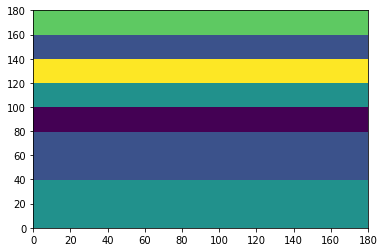

In [88]:
pcolor(P1, P2, np.abs(B[:,:,1]))

In [89]:
%timeit resonant_ring(0,0)

5.5 ms ± 53.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
D = 4.6e-3
A = pi * (D/2)**2
A

1.6619025137490005e-05

In [94]:
A * 140

0.002326663519248601

In [95]:
A * 5500

0.09140463825619502

In [97]:
40e6 / 730 * A

0.9106315143830139